# EDA

In [111]:
!pip install wordcloud
!pip install contractions
!pip install gensim
!pip install xgboost
!pip install pyLDAvis
!pip install imbalanced-learn

In [5]:
import pandas as pd
data = './TripleA.csv'
df = pd.read_csv(data)
print(df.columns)
print(df["Sentiment"].value_counts())

Index(['Review', 'Sentiment'], dtype='object')
Sentiment
Negative    538
Neutral     262
Positive    200
Name: count, dtype: int64


In [7]:
valid_sentiments = {"Positive", "Neutral", "Negative"}
unique_sentiments = set(df["Sentiment"].unique())

# Find invalid sentiment labels
invalid_sentiments = unique_sentiments - valid_sentiments

if invalid_sentiments:
    print("Unexpected sentiment labels found:", invalid_sentiments)
    invalid_rows = df[df["Sentiment"].isin(invalid_sentiments)]
    print(invalid_rows)
else:
    print("All sentiments are correctly labeled.")

All sentiments are correctly labeled.


In [9]:
df.describe()

,Review,Sentiment
count,1000,1000
unique,1000,3
top,Ive flown with them dozens of times and never ...,Negative
freq,1,538


In [11]:
df.groupby('Sentiment').describe()

Review                                                            \
           count unique                                                top   
Sentiment                                                                    
Negative     538    538  Within Thailand I have good experiences with t...   
Neutral      262    262  Thieving bass still owe me a 1000 usd I will n...   
Positive     200    200  Ive flown with them dozens of times and never ...   

                
          freq  
Sentiment       
Negative     1  
Neutral      1  
Positive     1

In [13]:
df['length']=df['Review'].apply(len)
df.head()

,Review,Sentiment,length
0,Ive flown with them dozens of times and never ...,Positive,66
1,Ive flown AirAsia Thai AirAsia and AirAsia Phi...,Positive,77
2,I have flown with them several times and never...,Positive,155
3,Within Thailand I have good experiences with t...,Negative,164
4,Same experience with AirAsia Japan,Negative,34


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

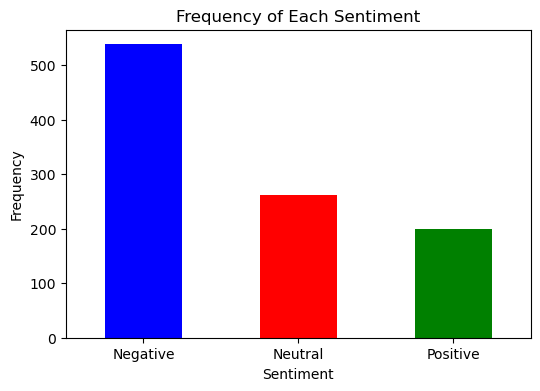

In [16]:
import matplotlib.pyplot as plt

# Count occurrences of each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Plot bar chart for sentiment distribution
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['blue', 'red', 'green'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Frequency of Each Sentiment')
plt.xticks(rotation=0)  # Keep labels horizontal
plt.show()


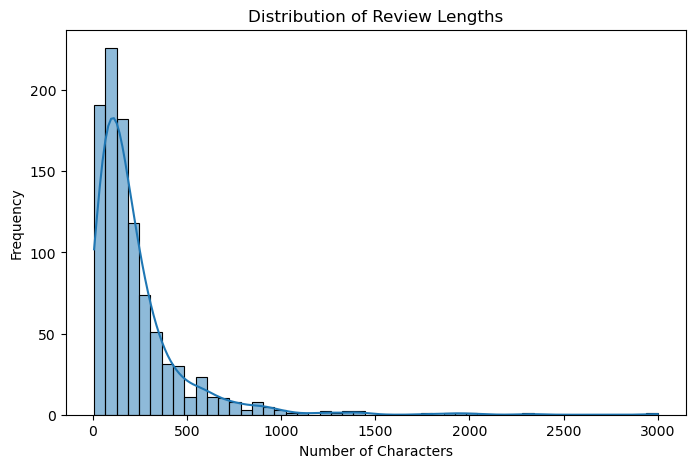

In [17]:
df['Review_Length'] = df['Review'].apply(lambda x: len(str(x)))

# Histogram of review lengths
plt.figure(figsize=(8, 5))
sns.histplot(df['Review_Length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


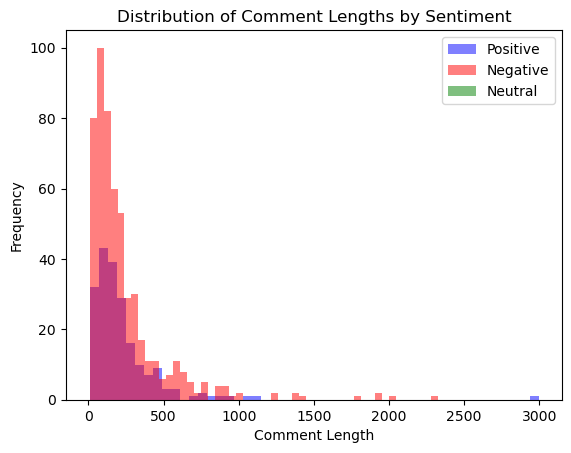

In [18]:
df[df['Sentiment'] == 'Positive']['length'].plot(bins=50, kind='hist', alpha=0.5, label='Positive', color='blue')
df[df['Sentiment'] == 'Negative']['length'].plot(bins=50, kind='hist', alpha=0.5, label='Negative', color='red')
df[df['Sentiment'] == 'neutral']['length'].plot(bins=50, kind='hist', alpha=0.5, label='Neutral', color='green')

plt.legend()
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Lengths by Sentiment')
plt.show()


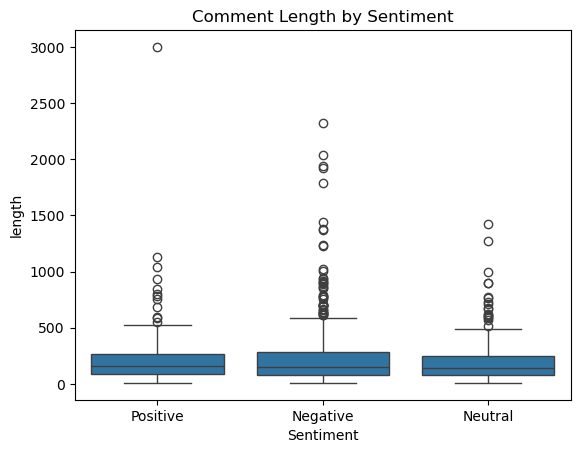

In [19]:
import seaborn as sns

sns.boxplot(x='Sentiment', y='length', data=df)
plt.title('Comment Length by Sentiment')
plt.show()


In [20]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=None, ngram_range=(2, 2)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

bigrams = get_top_ngrams(df['Review'].dropna(), n=10, ngram_range=(2, 2))
trigrams = get_top_ngrams(df['Review'].dropna(), n=10, ngram_range=(3, 3))

print("Top 10 Bigrams:", bigrams)
print("Top 10 Trigrams:", trigrams)


Top 10 Bigrams: [('air asia', 226), ('customer service', 57), ('budget airlines', 37), ('low cost', 36), ('budget airline', 26), ('credit card', 21), ('ive flown', 19), ('flight delayed', 18), ('pay extra', 15), ('customer support', 14)]
Top 10 Trigrams: [('fly air asia', 13), ('flew air asia', 11), ('low cost airline', 11), ('low cost carrier', 9), ('flown air asia', 7), ('air asia flight', 6), ('air asia worst', 6), ('air asia thailand', 6), ('flying air asia', 5), ('flight delayed hours', 5)]


# Text Preprocessing

## Lowercasing
Convert all text to lowercase to avoid case sensitivity issues.

In [26]:
df['Review'] = df['Review'].str.lower()
df.head()

,Review,Sentiment,length,Review_Length
0,ive flown with them dozens of times and never ...,Positive,66,66
1,ive flown airasia thai airasia and airasia phi...,Positive,77,77
2,i have flown with them several times and never...,Positive,155,155
3,within thailand i have good experiences with t...,Negative,164,164
4,same experience with airasia japan,Negative,34,34


## Removing Punctuation

In [30]:
import string
df['Review'] = df['Review'].str.translate(str.maketrans('', '', string.punctuation))

## Removing Numbers

In [34]:
df['Review'] = df['Review'].str.replace(r'\d+', '', regex=True)

## Removing Stopwords

In [38]:
import nltk
from nltk.corpus import stopwords
import contractions

nltk.download('stopwords')

def expand_and_remove_stopwords(text):
    expanded_text = contractions.fix(text)
    stop_words = set(stopwords.words('english'))
    words = expanded_text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

df['Review'] = df['Review'].apply(expand_and_remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/geraint/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review,Sentiment,length,Review_Length
0,flown dozens times never major issues,Positive,66,66
1,flown airasia thai airasia airasia philippines...,Positive,77,77
2,flown several times never problems weigh bag t...,Positive,155,155
3,within thailand good experiences flew air asia...,Negative,164,164
4,experience airasia japan,Negative,34,34


## Tokenization

In [40]:
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
df['ReviewTokens'] = df['Review'].apply(word_tokenize)

df.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/geraint/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Review,Sentiment,length,Review_Length,ReviewTokens
0,flown dozens times never major issues,Positive,66,66,"[flown, dozens, times, never, major, issues]"
1,flown airasia thai airasia airasia philippines...,Positive,77,77,"[flown, airasia, thai, airasia, airasia, phili..."
2,flown several times never problems weigh bag t...,Positive,155,155,"[flown, several, times, never, problems, weigh..."
3,within thailand good experiences flew air asia...,Negative,164,164,"[within, thailand, good, experiences, flew, ai..."
4,experience airasia japan,Negative,34,34,"[experience, airasia, japan]"


## Lemmatization

In [44]:
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['ReviewTokens'] = df['ReviewTokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

df.head()

[nltk_data] Downloading package wordnet to /Users/geraint/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Review,Sentiment,length,Review_Length,ReviewTokens
0,flown dozens times never major issues,Positive,66,66,"[flown, dozen, time, never, major, issue]"
1,flown airasia thai airasia airasia philippines...,Positive,77,77,"[flown, airasia, thai, airasia, airasia, phili..."
2,flown several times never problems weigh bag t...,Positive,155,155,"[flown, several, time, never, problem, weigh, ..."
3,within thailand good experiences flew air asia...,Negative,164,164,"[within, thailand, good, experience, flew, air..."
4,experience airasia japan,Negative,34,34,"[experience, airasia, japan]"


# Pipelines

In [46]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import gensim.downloader as api
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report

# Used to pass into N-gram and Vector Space
X = df['Review']
y = df['Sentiment']

# Used to pass into word embeddings
X_token = df['ReviewTokens']

# Splitting the dataset to 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Naïve Bayes": MultinomialNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = []

## N-gram Features vs. Unigram Features

In [48]:
ngram_models = {
    "Unigram": CountVectorizer(ngram_range=(1, 1)),
    "Bigram": CountVectorizer(ngram_range=(2, 2)),
    "Trigram": CountVectorizer(ngram_range=(3, 3)),
    "Combined N-Grams": CountVectorizer(ngram_range=(1, 3))
}

In [49]:
# Iterate over classifiers and n-gram models
for clf_name, clf in classifiers.items():
    print("=======================================================")
    print(clf_name)
    print("=======================================================")
    for ngram_name, vectorizer in ngram_models.items():
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', clf)
        ])
        
        # Train and test the model
        pipeline.fit(X_train, y_train)
        y_pred = cross_val_predict(pipeline, X_test, y_test, cv=5)
        
        # Evaluate performance
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print ("---------------------------------------------")
        print(ngram_name)
        print ("---------------------------------------------")
        print (classification_report(y_test, y_pred, zero_division=1))
        
        # Append results to list
        results.append(["N-Gram", clf_name, ngram_name, accuracy, precision, recall, f1])

Logistic Regression
---------------------------------------------
Unigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.82      0.69       117
     Neutral       0.26      0.12      0.17        48
    Positive       0.35      0.17      0.23        35

    accuracy                           0.54       200
   macro avg       0.40      0.37      0.36       200
weighted avg       0.48      0.54      0.49       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Bigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Trigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200

---------------------------------------------
Combined N-Grams
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.94      0.73       117
     Neutral       0.42      0.10      0.17        48
    Positive       0.40      0.06      0.10        35

    accuracy                           0.58       200
   macro avg       0.47      0.37      0.33       200
weighted avg       0.52      0.58      0.49       200

Random Forest
---------------

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Bigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Trigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Combined N-Grams
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200

Support Vector Machine


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Unigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Bigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Trigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Combined N-Grams
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200

Naïve Bayes
---------------------------------------------
Unigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.61      0.86      0.72       117
     Neutral       0.28      0.15      0.19        48
    Positive       0.40      0.11      0.18        35

    accuracy                           0.56       200
   macro avg       0.43      0.37      0.36       200
weighted avg       0.50      0.56      0.50       200

-----------------

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Trigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.59      0.99      0.74       117
     Neutral       0.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.53      0.33      0.25       200
weighted avg       0.52      0.58      0.43       200

---------------------------------------------
Combined N-Grams
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.97      0.74       117
     Neutral       0.45      0.10      0.17        48
    Positive       0.00      0.00      0.00        35

    accuracy                           0.59       200
   macro avg       0.35      0.36      0.30       200
weighted avg       0.46      0.59      0.48       200

Gradient Boosting
-----------

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Trigram
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200

---------------------------------------------
Combined N-Grams
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.59      0.87      0.70       117
     Neutral       0.12      0.04      0.06        48
    Positive       0.09      0.03      0.04        35

    accuracy                           0.53       200
   macro avg       0.27      0.31      0.27       200
weighted avg       0.39      0.53      0.43       200



## Vector Space 

In [52]:
vector_space_models = {
    "Binary Representation": CountVectorizer(binary=True),
    "Frequency Count": CountVectorizer(max_features=10000, max_df=.15),
    "TF-IDF": TfidfVectorizer(max_features=10000, max_df=.15)
}

In [53]:
for clf_name, clf in classifiers.items():
    print("=======================================================")
    print(clf_name)
    print("=======================================================")
    for vector_name, vectorizer in vector_space_models.items():
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', clf)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = cross_val_predict(pipeline, X_test, y_test, cv=5)
        
        # Evaluate performance
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')   
        print ("---------------------------------------------")
        print(vector_name)
        print ("---------------------------------------------")
        print (classification_report(y_test, y_pred, zero_division=1))
        
        # Append results to list
        results.append(["Vector Space", clf_name, vector_name, accuracy, precision, recall, f1])

Logistic Regression
---------------------------------------------
Binary Representation
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.84      0.70       117
     Neutral       0.17      0.08      0.11        48
    Positive       0.43      0.17      0.24        35

    accuracy                           0.54       200
   macro avg       0.40      0.36      0.35       200
weighted avg       0.47      0.54      0.48       200

---------------------------------------------
Frequency Count
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.86      0.71       117
     Neutral       0.33      0.12      0.18        48
    Positive       0.33      0.14      0.20        35

    accuracy                           0.56       200
   macro avg       0.42      0.38      0.36       200
weighted avg       0.49      0.56      0.49       2

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Binary Representation
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      0.89      0.70       117
     Neutral       0.17      0.04      0.07        48
    Positive       0.00      0.00      0.00        35

    accuracy                           0.53       200
   macro avg       0.25      0.31      0.26       200
weighted avg       0.38      0.53      0.43       200

---------------------------------------------
Frequency Count
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.59      0.90      0.71       117
     Neutral       0.29      0.08      0.13        48
    Positive       0.11      0.03      0.05        35

    accuracy                           0.55       200
   macro avg       0.33      0.34      0.30       200
weighted avg       0.44      0.55      0.46       200

----------------

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Binary Representation
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
Frequency Count
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---------------------------------------------
TF-IDF
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.58      1.00      0.74       117
     Neutral       1.00      0.00      0.00        48
    Positive       1.00      0.00      0.00        35

    accuracy                           0.58       200
   macro avg       0.86      0.33      0.25       200
weighted avg       0.76      0.58      0.43       200

Naïve Bayes
---------------------------------------------
Binary Representation
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.63      0.89      0.73       117
     Neutral       0.33      0.15      0.20        48
    Positive       0.31      0.11      0.17        35

    accuracy                           0.57       200
   macro avg       0.42      0.38      0.37       200
weighted avg       0.50      0.57      0.51       200

-------------

## Word Embeddings

In [57]:
classifiers1 = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [ ]:
# Load pretrained Word2Vec (Google News)
word2vec = api.load("word2vec-google-news-300")

# Load pretrained GloVe
glove_vectors = api.load("glove-twitter-25")

# Function to convert text to word embeddings
def get_embedding(tokens, model):
    """
    Generates an average word embedding for a list of tokens.
    """
    word_vectors = [model[word] for word in tokens if word in model]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Convert text data to embeddings
X_word2vec = np.array([get_embedding(text, word2vec) for text in X_token])
X_glove = np.array([get_embedding(text, glove_vectors) for text in X_token])

# Train-test split for word embeddings
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y, test_size=0.2, random_state=42)

# Test classifiers on word embeddings
for clf_name, clf in classifiers1.items():
    print("=======================================================")
    print(clf_name)
    print("=======================================================")
    # Word2Vec
    clf.fit(X_train_w2v, y_train_w2v)
    y_pred_w2v = clf.predict(X_test_w2v)
    
    # Evaluate
    accuracy_w2v = accuracy_score(y_test_w2v, y_pred_w2v)
    precision_w2v = precision_score(y_test_w2v, y_pred_w2v, average='weighted')
    recall_w2v = recall_score(y_test_w2v, y_pred_w2v, average='weighted')
    f1_w2v = f1_score(y_test_w2v, y_pred_w2v, average='weighted')

    print ("---------------------------------------------")
    print("Word2Vec")
    print ("---------------------------------------------")
    print (classification_report(y_test_w2v, y_pred_w2v, zero_division=1))
    
    results.append(["Word Embedding", clf_name, "Word2Vec", accuracy_w2v, precision_w2v, recall_w2v, f1_w2v])
    
    # GloVe
    clf.fit(X_train_glove, y_train_glove)
    y_pred_glove = clf.predict(X_test_glove)
    
    # Evaluate
    accuracy_glove = accuracy_score(y_test_glove, y_pred_glove)
    precision_glove = precision_score(y_test_glove, y_pred_glove, average='weighted')
    recall_glove = recall_score(y_test_glove, y_pred_glove, average='weighted')
    f1_glove = f1_score(y_test_glove, y_pred_glove, average='weighted')

    print ("---------------------------------------------")
    print("GloVe")
    print ("---------------------------------------------")
    print (classification_report(y_test_glove, y_pred_glove, zero_division=1))
    
    results.append(["Word Embedding", clf_name, "GloVe", accuracy_glove, precision_glove, recall_glove, f1_glove])

Logistic Regression
---------------------------------------------
Word2Vec
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.71      0.91      0.80       117
     Neutral       0.57      0.35      0.44        48
    Positive       0.62      0.37      0.46        35

    accuracy                           0.68       200
   macro avg       0.63      0.54      0.57       200
weighted avg       0.66      0.68      0.65       200

---------------------------------------------
GloVe
---------------------------------------------
              precision    recall  f1-score   support

    Negative       0.63      0.90      0.74       117
     Neutral       0.38      0.06      0.11        48
    Positive       0.48      0.34      0.40        35

    accuracy                           0.60       200
   macro avg       0.49      0.43      0.42       200
weighted avg       0.54      0.60      0.53       200

Random Forest
-----

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Convert results into a DataFrame
df_results = pd.DataFrame(results, columns=["Representation Type", "Classifier", "Feature Type", "Accuracy", "Precision", "Recall", "F1-Score"])

# Apply styling
styled_df = df_results.style.format(precision=4).highlight_max(subset=["Accuracy", "Precision", "Recall", "F1-Score"])

# Display the styled table
display(styled_df)

# Visualization and Insights

In [ ]:
from wordcloud import WordCloud

# Combine all reviews
all_words = ' '.join(df['Review'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()


In [ ]:
for sentiment in df['Sentiment'].unique():
    text = ' '.join(df[df['Sentiment'] == sentiment]['Review'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Common Words in {sentiment} Reviews')
    plt.show()


In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce dimensionality of Word2Vec embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_word2vec)  # Replace with X_glove for GloVe

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization of Word2Vec Embeddings")
plt.show()


In [ ]:
positive_review = df[df['Sentiment'] == 'Positive']
negative_review = df[df['Sentiment'] == 'Negative']

In [ ]:
from collections import Counter

# Define words to exclude
exclude_words = {'airasia', 'aa', 'asia', 'air', 'flight', 'airline'}

# Flatten and filter words for positive and negative reviews
positive_words = [word for tokens in positive_review['ReviewTokens'] 
                  for word in tokens if word.lower() not in exclude_words]
negative_words = [word for tokens in negative_review['ReviewTokens'] 
                  for word in tokens if word.lower() not in exclude_words]

# Count word frequencies
common_positive = Counter(positive_words).most_common(10)
common_negative = Counter(negative_words).most_common(10)

print("Most common words in Positive reviews:", common_positive)
print("Most common words in Negative reviews:", common_negative)


In [ ]:
import gensim
import pyLDAvis
import pyLDAvis.gensim
from gensim import corpora

pyLDAvis.enable_notebook()

In [ ]:
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim
import gensim

positive_reviews = df[df['Sentiment'] == "Positive"]['ReviewTokens'].tolist()
negative_reviews = df[df['Sentiment'] == "Negative"]['ReviewTokens'].tolist()

positive_reviews = [eval(tokens) if isinstance(tokens, str) else tokens for tokens in positive_reviews]
negative_reviews = [eval(tokens) if isinstance(tokens, str) else tokens for tokens in negative_reviews]

def train_lda(reviews, num_topics):
    dictionary = corpora.Dictionary(reviews)
    corpus = [dictionary.doc2bow(text) for text in reviews]
    lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=20, workers=2)
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    return vis

lda_normal = train_lda(df['ReviewTokens'].tolist(), 5)
pyLDAvis.display(lda_normal)

In [ ]:
lda_vis_negative = train_lda(negative_reviews, 5)
pyLDAvis.display(lda_vis_negative) 

In [ ]:
lda_vis_positive = train_lda(positive_reviews, 5)
pyLDAvis.display(lda_vis_positive)